In [ ]:

import numpy as np
import pandas as pd
import torch
import string
import collections



#Viz Libs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

#Text cleaning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Getting the tokenizer and the model
!pip install transformers

from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 8.0 MB/s 
     |████████████████████████████████| 596 kB 71.5 MB/s 
     |████████████████████████████████| 101 kB 13.1 MB/s 
     |████████████████████████████████| 6.6 MB 34.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
import pandas

headlines_df = pandas.read_csv('./TWEETS_AND_HEADLINES_FILTERED.csv', error_bad_lines=False, engine='python')
headlines_df.reset_index()
df_results = pandas.DataFrame()
headlines_df

Skipping line 34453: unexpected end of data


,date,headline
0,07-01-2018,"Gonna put an old school drive-in, roller skate..."
1,07-01-2018,@omerldiri @Tesla Good idea. We can just have ...
2,09-01-2018,@Mister_Millard @Tesla That sounds cool. Will do.
3,09-01-2018,@PPathole @Tesla @Teslarati @MKBHD Fixed in ne...
4,29-01-2018,@JosephHuberman @Tesla Coming soon
...,...,...
34446,25-05-2022,Im only half as invested in TSLA shorts as I u...
34447,25-05-2022,"Wow, congratulations. You found people who thi..."
34448,25-05-2022,[😂😂😂😂 TSLA junk and over valued buddy. I have ...
34449,25-05-2022,"They are sort of right, that does not make bit..."


In [ ]:
headlines_df['headline'] =  headlines_df['headline'].astype(str)

In [ ]:
#headlines_df = headlines_df.sample(10000)
headlines_df


,date,headline
0,07-01-2018,"Gonna put an old school drive-in, roller skate..."
1,07-01-2018,@omerldiri @Tesla Good idea. We can just have ...
2,09-01-2018,@Mister_Millard @Tesla That sounds cool. Will do.
3,09-01-2018,@PPathole @Tesla @Teslarati @MKBHD Fixed in ne...
4,29-01-2018,@JosephHuberman @Tesla Coming soon
...,...,...
34446,25-05-2022,Im only half as invested in TSLA shorts as I u...
34447,25-05-2022,"Wow, congratulations. You found people who thi..."
34448,25-05-2022,[😂😂😂😂 TSLA junk and over valued buddy. I have ...
34449,25-05-2022,"They are sort of right, that does not make bit..."


In [ ]:
#Removing mentions and URLs from text column.
import datetime
import re
def filterUrls(row):
  row.headline=re.sub(r'^https?:\/\/.*[\r\n]*', '', row.headline, flags=re.MULTILINE)
  row.headline=re.sub(r'^http?:\/\/.*[\r\n]*', '', row.headline, flags=re.MULTILINE)
  row.headline=re.sub(r'^/r/?:\/\/.*[\r\n]*', '', row.headline, flags=re.MULTILINE)
  row.headline = re.sub('@[A-Za-z0-9]+','',  row.headline, flags=re.MULTILINE)
  return row
headlines_df=headlines_df.apply(filterUrls, axis=1)

In [ ]:
class CleanText(BaseEstimator, TransformerMixin):
  #Normalizing Text by converting text to lowercase, removing URLs, punctuation and removing digits and Emojis
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    import nltk
    nltk.download("stopwords")
    from nltk.corpus import stopwords
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 

#Porter Stemmer Used for stemming
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [ ]:
ct = CleanText()

headlines_df['headline'] = ct.fit_transform(headlines_df.headline)


In [ ]:
#That's where the headlines get tokenized to be inputted into model
import torch
import pandas as pd

def predictSentiment(headlines_list):
  inputs = tokenizer(headlines_list, padding = True, truncation = True, return_tensors='pt').to('cuda:0')
  #inference
  outputs = model(**inputs)
  #Postprocessing with softmax
  predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
  #Model classes
  return predictions

In [ ]:

import gc

i =0;
batch_size=10
while i < len(headlines_df):
#len(headlines_df.index):
  if i+(batch_size-1)<len(headlines_df):
    headlines_loop=headlines_df.loc[i:i+(batch_size-1)]
  else:
    headlines_loop = headlines_df[i:]
  headlines_list = list(headlines_loop['headline'])
  dates_list = list(headlines_loop['date'])
  predictions =  predictSentiment(headlines_list)
  positive = predictions[:, 0].tolist()
  negative = predictions[:, 1].tolist()
  neutral = predictions[:, 2].tolist()

  table = {'Date':dates_list,
         'Headline':headlines_list,
         "Positive":positive,
         "Negative":negative, 
         "Neutral":neutral}
  df_temp = pd.DataFrame(table, columns = ["Date","Headline", "Positive", "Negative", "Neutral"])
  df_results = df_results.append(df_temp)
  predictions, positive, negative, neutral = [], [],[],[]
  gc.collect()
  torch.cuda.empty_cache()
  i=i+batch_size


In [ ]:
df_results['Positive']=df_results['Positive'].astype('float64')
df_results['Negative']=df_results['Negative'].astype('float64')
df_results['Neutral']=df_results['Neutral'].astype('float64')
df_results = df_results.groupby('Date')['Positive','Negative','Neutral'].agg('mean')

In [ ]:
df_results

,Positive,Negative,Neutral
Date,,,
01-01-2019,0.051738,0.023977,0.924285
01-01-2020,0.140968,0.014544,0.844489
01-01-2022,0.118035,0.076562,0.805403
01-02-2019,0.037721,0.020432,0.941847
01-02-2020,0.108922,0.023368,0.867710
...,...,...,...
31-10-2018,0.108383,0.016917,0.874700
31-10-2021,0.077797,0.055493,0.866710
31-12-2018,0.741892,0.011059,0.247049


In [ ]:
df_numeric = df_results[["Positive","Negative", "Neutral"]]
df_results['Label'] = df_numeric[["Positive","Negative"]].idxmax(axis=1)


In [ ]:
#Formatting the results as a pandas data frame
df_results
df_results.sort_values(by='Date', inplace=True)
df_results.to_csv('PREDICTED_SENTIMENT.csv')


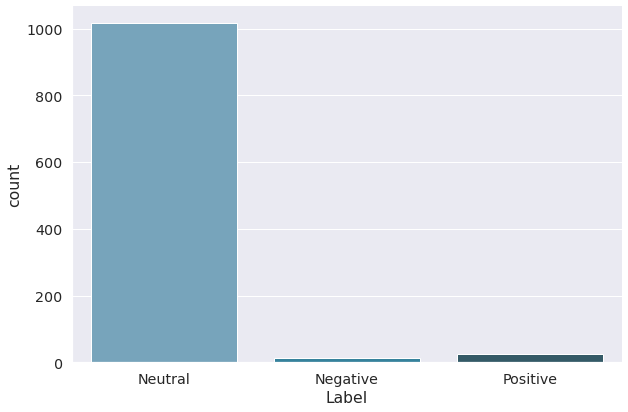

In [ ]:
sns.factorplot(x="Label", data=df_results, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();